# Flight Price Prediction

### Importing dataset and doing feature engineering

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import pickle
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression

In [2]:
rawdf = pd.read_excel("./Data_Train.xlsx")
pd.set_option('display.max_columns',None)
rawdf.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [3]:
#Handle missing Data
rawdf.dropna(inplace = True)
rawdf.shape

(10682, 11)

In [4]:
rawdf.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


### Handle Continuous Data

In [5]:
rawdf['DOJ_day'] = pd.to_datetime(rawdf['Date_of_Journey'], format="%d/%m/%Y").dt.day
rawdf['DOJ_month'] = pd.to_datetime(rawdf['Date_of_Journey'], format="%d/%m/%Y").dt.month
del rawdf['Date_of_Journey']

rawdf['Dep_hour'] = pd.to_datetime(rawdf['Dep_Time']).dt.hour
rawdf['Dep_min'] = pd.to_datetime(rawdf['Dep_Time']).dt.minute
del rawdf['Dep_Time']

rawdf['Arr_hour'] = pd.to_datetime(rawdf['Arrival_Time']).dt.hour
rawdf['Arr_min'] = pd.to_datetime(rawdf['Arrival_Time']).dt.minute
del rawdf['Arrival_Time']

<b> _Split Duration in Hr and Min_

In [6]:
Duration_hr =[]
Duration_min =[]

for txt in rawdf['Duration']:
    temp = txt.split() 
    if len(temp)==2:  
        if 'h' in temp[0]:
            Duration_hr.append(int(temp[0].strip('h')))
        else:
            Duration_hr.append(0)
    
        if 'm' in temp[1]:
            Duration_min.append(int(temp[1].strip('m')))
    else:
        if 'h' in temp[0]:
            Duration_hr.append(int(temp[0].strip('h')))   
            Duration_min.append(0)
        else:
            Duration_min.append(int(temp[0].strip('m')))   
            Duration_hr.append(0)
    
rawdf['Duration_hr'] = Duration_hr
rawdf['Duration_min'] = Duration_min
del rawdf['Duration']

<b> _Since we have no of stops as one of our feature we dont require Route feature_

In [7]:
del rawdf['Route']
del rawdf['Additional_Info']

### Handle Nominal Data

In [8]:
Airlines = pd.get_dummies(rawdf.Airline, drop_first=True)
Source = pd.get_dummies(rawdf['Source'], drop_first=True)
Destination = pd.get_dummies(rawdf['Destination'], drop_first=True)
if("Kolkata" in list(Destination.columns)):
    Destination.rename(columns= {'Kolkata': 'Calcutta'}, inplace = True)
if("Delhi" in list(Destination.columns)):
    Destination.rename(columns= {'Delhi': 'Del'}, inplace = True)
del rawdf['Source']
del rawdf['Destination']
del rawdf['Airline']

### Handle Ordinal Data

In [9]:
rawdf.replace({"non-stop":0,"1 stop":1,"2 stops":2,"3 stops":3,"4 stops":4},inplace=True)

In [10]:
traindf = pd.concat([rawdf,Airlines,Source,Destination],axis=1)
traindf.head()

,Total_Stops,Price,DOJ_day,DOJ_month,Dep_hour,Dep_min,Arr_hour,Arr_min,Duration_hr,Duration_min,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Del,Hyderabad,Calcutta,New Delhi
0,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Getting data insights
   * <b> Heatmap plot to find feature coorelations

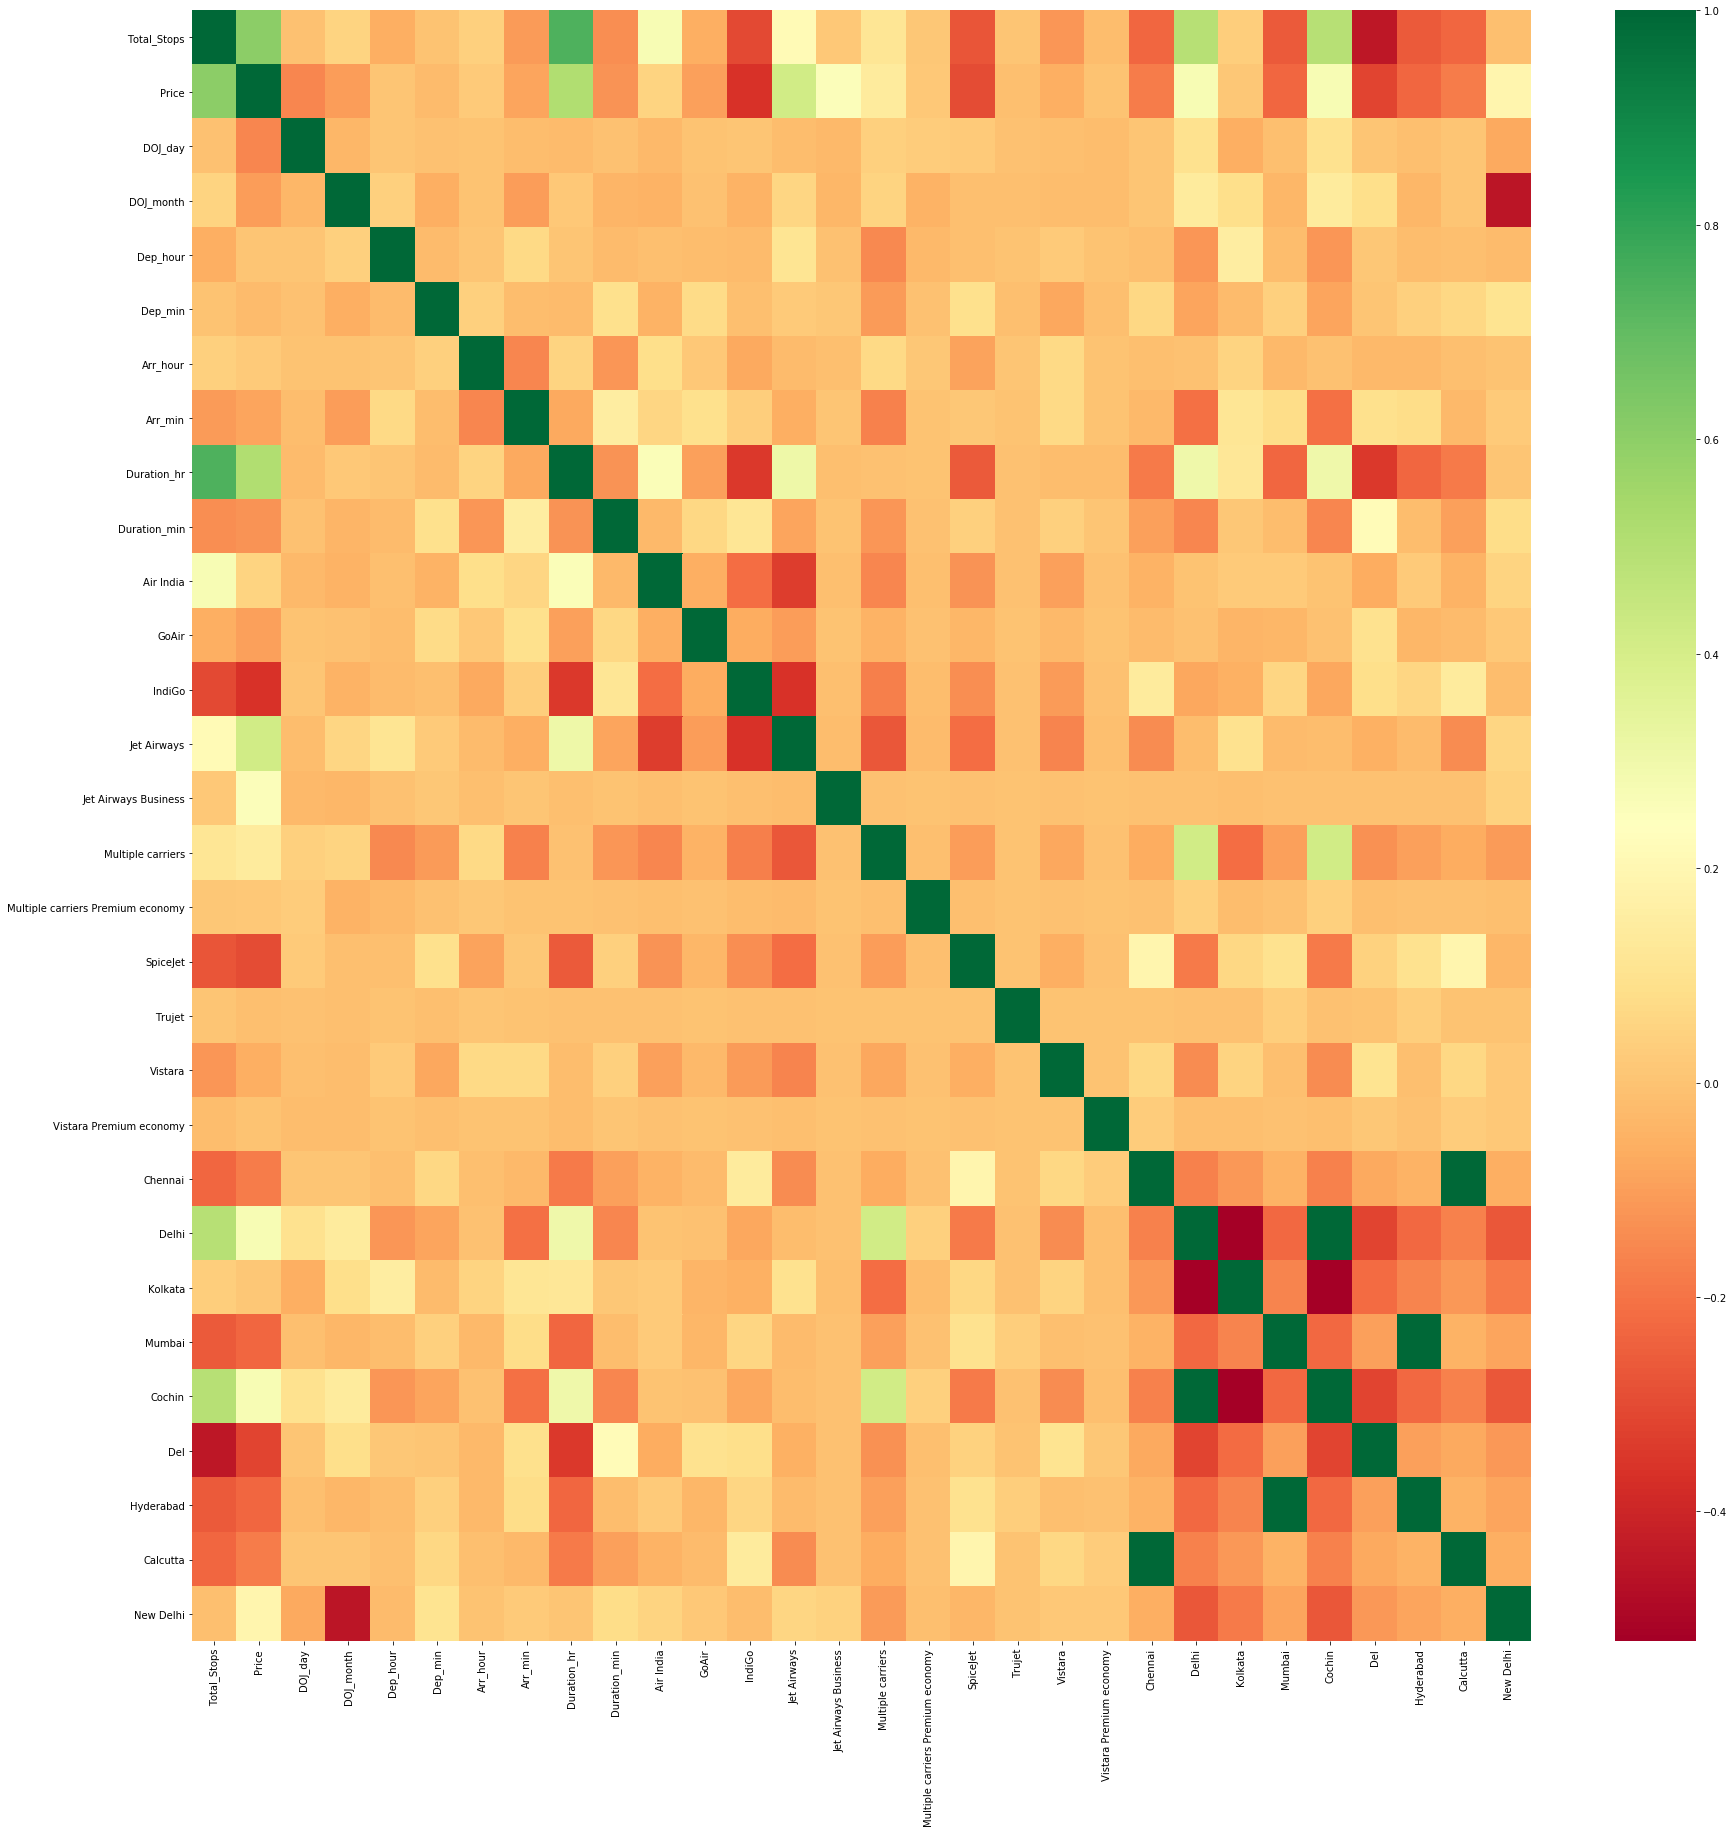

In [18]:
plt.figure(figsize=(30,30))
sns.heatmap(traindf.corr(),cmap='RdYlGn')
plt.show()

   *<b> Price Distribution - Density plot

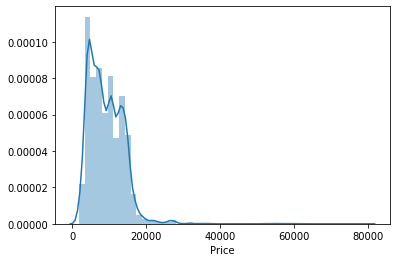

In [21]:
sns.distplot(traindf['Price'])

### Feature Extraction 
    * Spliting of dependent and independent data 
    * Droping the features having least importance

In [11]:
X = traindf.drop('Price',axis=1)
Y = traindf['Price']

selection = ExtraTreesRegressor()
selection.fit(X,Y)
dictio = {'Features':X.columns, 'Importance':selection.feature_importances_}
feature_select = pd.DataFrame(dictio)
feature_select = feature_select.sort_values(by='Importance')
print(feature_select)

                             Features  Importance
19            Vistara Premium economy    0.000091
17                             Trujet    0.000105
20                            Chennai    0.000512
27                           Calcutta    0.000566
15  Multiple carriers Premium economy    0.000884
10                              GoAir    0.001828
16                           SpiceJet    0.002680
22                            Kolkata    0.003331
18                            Vistara    0.005002
26                          Hyderabad    0.006095
23                             Mumbai    0.007503
21                              Delhi    0.009487
9                           Air India    0.009836
24                             Cochin    0.012044
25                                Del    0.014980
8                        Duration_min    0.017166
11                             IndiGo    0.017798
6                             Arr_min    0.019071
14                  Multiple carriers    0.020098


<b> Plotting of feature importance

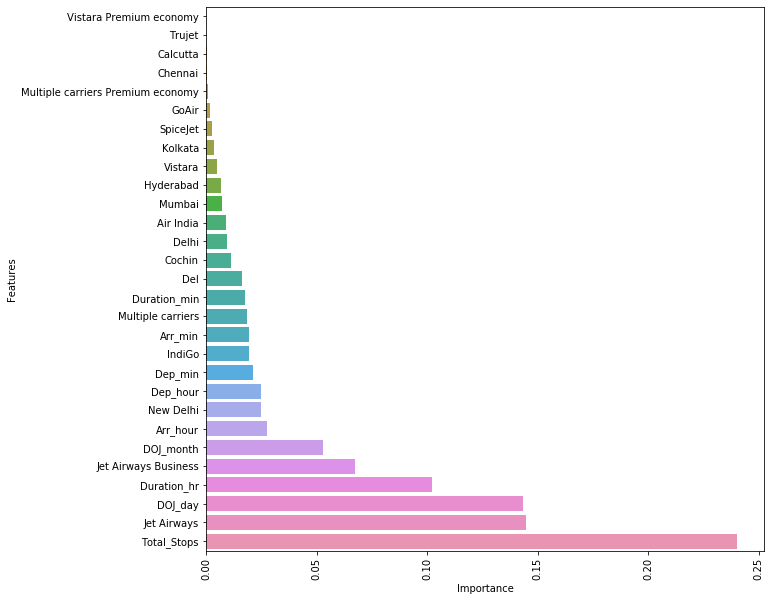

In [24]:
plt.figure(figsize=(10,10))
sns.barplot(x='Importance', y='Features',data=feature_select)
plt.xticks(rotation=90)
plt.show()

As from the above plot it is evident that 'Vistara Premium economy','Trujet','Calcutta','Chennai','Multiple carriers Premium economy' are having least feature importance hence removing these features


In [12]:
del X['Vistara Premium economy']
del X['Trujet']
del X['Calcutta']
del X['Chennai']
del X['Multiple carriers Premium economy']

### Generate Pipeline to apply various models

In [13]:
pipelr = Pipeline([('scalar1',StandardScaler()), ('lr_regresor',LinearRegression())])
pipelogi = Pipeline([('scalar2',StandardScaler()), ('logi_regresor',LogisticRegression())])
pipesvm = Pipeline([('scalar3',StandardScaler()), ('svm_regresor',SVC())])
piperf= Pipeline([('rf_regresor',RandomForestRegressor())])
pipexg= Pipeline([('xgb_regresor',XGBRegressor())])

pipelines = [pipelr,pipelogi,pipesvm,piperf,pipexg]
models = ['linear Reg','logi Reg','SVM Reg', 'Random Reg', 'XGB Reg']

xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size=0.3,random_state=12)
for pipe in pipelines:
    pipe.fit(xtrain,ytrain)

for i,model in enumerate(pipelines):
    print("{} model score = {}".format(models[i],model.score(xtest,ytest)))

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


linear Reg model score = 0.6091828311393379
logi Reg model score = 0.3407176287051482
SVM Reg model score = 0.31357254290171604
Random Reg model score = 0.758650682758288
XGB Reg model score = 0.8163910863209402


<b> _From above pipeline its evident that XGBoost has outperformed all other models_

### Hypertuning XGBoost using randomized search CV

In [16]:
parameters = {'eta':[0.01,0.1,0.3,0.5,1],'gamma':[0.1,0,10,100,500], 'max_depth':[6,10,15,20,30]}
                            
random = RandomizedSearchCV(estimator = XGBRegressor(), 
                   param_distributions = parameters,
                   scoring = 'neg_mean_squared_error',
                   cv=3, n_iter = 5, verbose=2)
random.fit(xtrain,ytrain)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] max_depth=30, gamma=0, eta=0.01 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. max_depth=30, gamma=0, eta=0.01, total=   2.3s
[CV] max_depth=30, gamma=0, eta=0.01 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] .................. max_depth=30, gamma=0, eta=0.01, total=   1.8s
[CV] max_depth=30, gamma=0, eta=0.01 .................................
[CV] .................. max_depth=30, gamma=0, eta=0.01, total=   1.6s
[CV] max_depth=30, gamma=0, eta=0.1 ..................................
[CV] ................... max_depth=30, gamma=0, eta=0.1, total=   3.6s
[CV] max_depth=30, gamma=0, eta=0.1 ..................................
[CV] ................... max_depth=30, gamma=0, eta=0.1, total=   3.6s
[CV] max_depth=30, gamma=0, eta=0.1 ..................................
[CV] ................... max_depth=30, gamma=0, eta=0.1, total=   3.7s
[CV] max_depth=20, gamma=500, eta=1 ..................................
[CV] ................... max_depth=20, gamma=500, eta=1, total=   3.8s
[CV] max_depth=20, gamma=500, eta=1 ..................................
[CV] ................... max_depth=20, gamma=500, eta=1, total=   3.7s
[CV] max_depth=20, gamma=500, eta=1 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   34.0s finished


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, reg_alpha=None,
                                       

<b> Getting best extimators

In [18]:
random.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0.1,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0.1,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=np.nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
model.fit(xtest,ytest)
print("model score for test data -> ",model.score(xtest,ytest))

model score for test data ->  0.9617295190121792


In [42]:
model.fit(xtest,ytest)
ypred = model.predict(xtest)
print("Pearson Cooreation between predicted and actual data -> %.2f" % pearsonr(ytest,ypred)[0])
print("MSE between predicted and actual data -> %.2f" % mean_squared_error(ytest,ypred))
print("R2 score between predicted and actual data -> %.2f" % r2_score(ytest,ypred))

Pearson Cooreation between predicted and actual data -> 0.98
MSE between predicted and actual data -> 798297.26
R2 score between predicted and actual data -> 0.96


<b> Scatter plot: Actual Vs Predicted

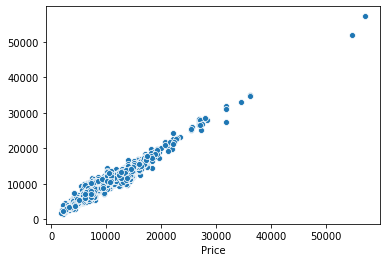

In [43]:
sns.scatterplot(ytest,ypred)

<b> Density plot: Actual Vs Predicted

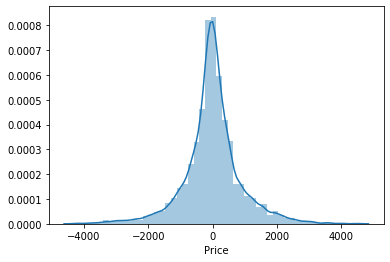

In [44]:
sns.distplot(ytest-ypred)